In [237]:
from __future__ import absolute_import,division,print_function,unicode_literals

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import os
from datetime import datetime

import pandas as pd

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from download import download

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error as mse

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

print("Import Succesfull")

Import Succesfull


In [238]:
import os
os.chdir(r"C:\Users\eanusau\Documents\AI\Stat\Projects\TimeSeries")

    Industrial Production: Electric and gas utilities (IPG2211A2N)
    Not Seasonally Adjusted
    Frequency:Monthly
    https://fred.stlouisfed.org/series/IPG2211A2N
    The industrial production (IP) index measures the real output of all relevant establishments located in the United  
    States

In [239]:
data = pd.read_csv('Electric_Production.csv')
df = data.copy()
df.head()

,DATE,IPG2211A2N
0,1939-01-01,3.3842
1,1939-02-01,3.4100
2,1939-03-01,3.4875
3,1939-04-01,3.5133
4,1939-05-01,3.5133


In [240]:
df.columns = ['Date', 'Energy Production']

In [241]:
df

,Date,Energy Production
0,1939-01-01,3.3842
1,1939-02-01,3.4100
2,1939-03-01,3.4875
3,1939-04-01,3.5133
4,1939-05-01,3.5133
...,...,...
974,2020-03-01,97.8951
975,2020-04-01,86.3541
976,2020-05-01,86.9068
977,2020-06-01,99.5332


<AxesSubplot:>

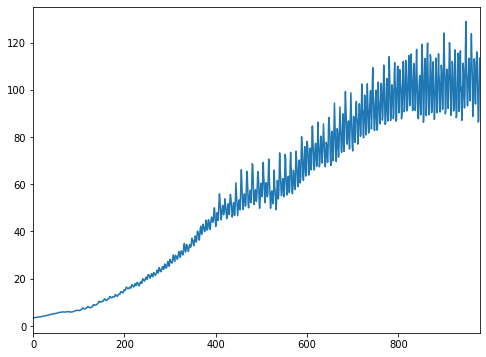

In [242]:
df['Energy Production'].plot()

In [243]:
df['Date']  = df['Date'].astype('datetime64[ns]')

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979 entries, 0 to 978
Data columns (total 2 columns):
Date                 979 non-null datetime64[ns]
Energy Production    979 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.4 KB


In [245]:
import plotly.express as px
fig = px.line(df, x = 'Date',y = 'Energy Production',title = 'Energy_Production')

fig.update_xaxes(
    rangeslider_visible= True,
    rangeselector=dict(
                        buttons = list([
                        dict(count = 1,label = '1m',step='month',stepmode = "backward"),
                        dict(count = 2,label = '6m',step='month',stepmode = "backward"),
                        dict(count = 3,label = '6mYTD',step='month',stepmode = "todate"),
                        dict(count = 4,label = '2y',step='year',stepmode = "backward"),
                        dict(count = 5,label = '3y',step='year',stepmode = "backward"),
                        dict(step= 'all')
                            ])        
                        )
                   )
fig.show()

In [246]:
df.set_index('Date', inplace=True)

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 979 entries, 1939-01-01 to 2020-07-01
Data columns (total 1 columns):
Energy Production    979 non-null float64
dtypes: float64(1)
memory usage: 15.3 KB


<AxesSubplot:xlabel='Date'>

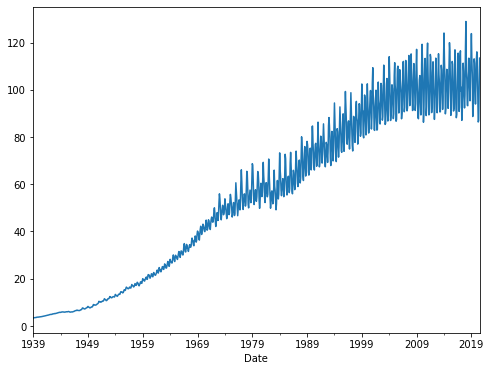

In [248]:
df['Energy Production'].plot()

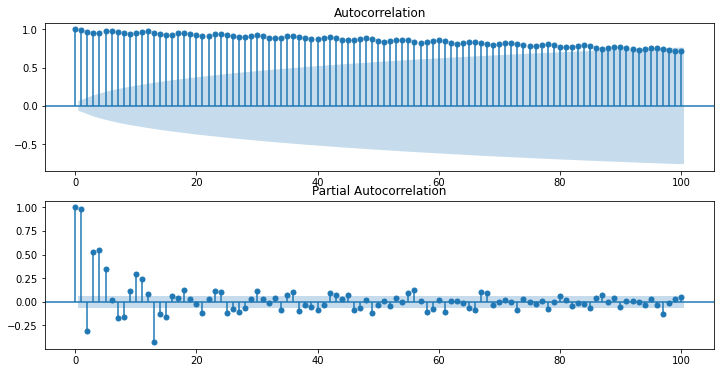

In [249]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df['Energy Production'].dropna(), ax=ax[0], lags=100)
ax[1] = plot_pacf(df['Energy Production'].dropna(), ax=ax[1], lags=100)

In [250]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        test_statistic = sm.tsa.stattools.adfuller(y,regresults=True)[0]
        p_value = sm.tsa.stattools.adfuller(y)[1]
        print("Test statistic = {:.3f}".format(test_statistic))
        print("P-value = {:.3f}".format(p_value))
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

Test statistic = -0.721
P-value = 0.841


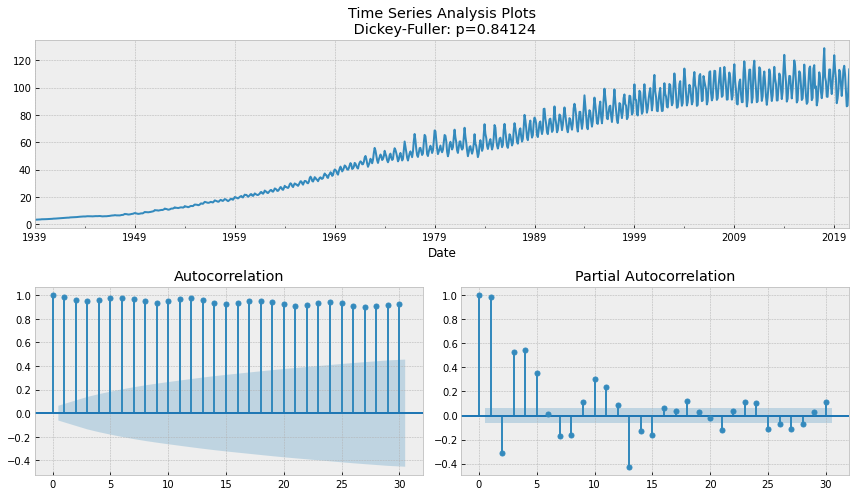

In [251]:
tsplot(df['Energy Production'])

In [252]:
## MAPE

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/ y_true)) * 100

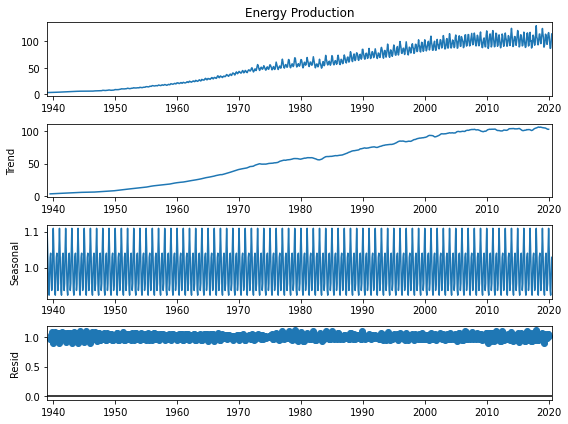

In [253]:
## Decomposition of time series

import statsmodels.api as sm
# deal with missing values.
df['Energy Production'].interpolate(inplace=True)
res = sm.tsa.seasonal_decompose(df['Energy Production'],model='multiplicative')
resplot = res.plot()

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 979 entries, 1939-01-01 to 2020-07-01
Data columns (total 1 columns):
Energy Production    979 non-null float64
dtypes: float64(1)
memory usage: 15.3 KB


In [255]:
#H0: Series is stationary
#H1: Series is not stationary

from statsmodels.tsa.stattools import kpss
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')


stats, p, lags, critical_values = kpss(df['Energy Production'], 'c')
print(f'Test Statistics: {stats}')
print(f'p-value: {p}')
print(f'Critical values: {critical_values}')

if p < 0.05:
    print('\nWe reject the null hypothesis i.e. Series is not stationary')
else:
    print('\nWe fail to reject the null hypothesis i.e. Series is stationary')


Test Statistics: 4.364620318120944
p-value: 0.01
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

We reject the null hypothesis i.e. Series is not stationary


In [256]:
# Adfuller test

   # Ho: Series possess a unit root and hence is not stationary
   # H1: Series is stationary

from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Energy Production'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical values: {result[4]}')

if result[1] < 0.05:
    print('\nWe reject the null hypothesis i.e. Series is stationary')
else:
    print('\nWe fail to reject the null hypothesis i.e. Series is NOT stationary')

Test Statistics: -0.7209808933942852
p-value: 0.8412399105457927
Critical values: {'1%': -3.4372087295925664, '5%': -2.8645680048962348, '10%': -2.5683822785402914}

We fail to reject the null hypothesis i.e. Series is NOT stationary


# Using SARIMA

Test statistic = -0.721
P-value = 0.841


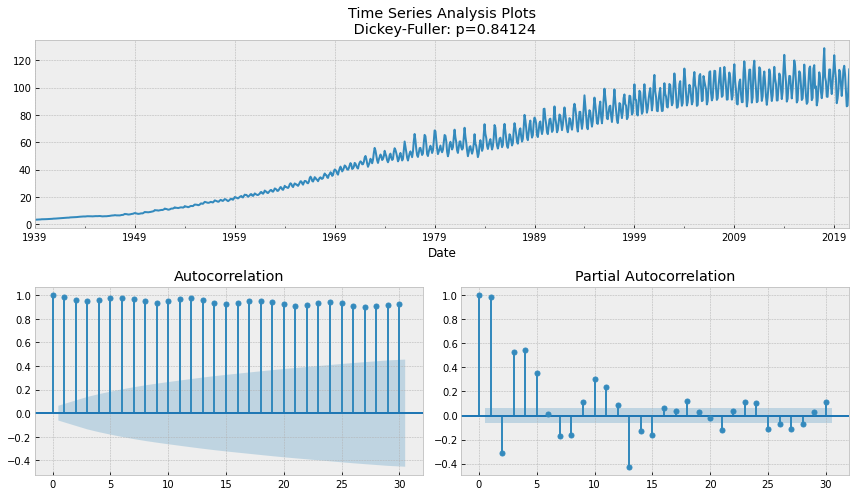

In [257]:
tsplot(df['Energy Production'])

In [258]:
df_diff1 = df['Energy Production'] - df['Energy Production'].shift(1)

Test statistic = -9.616
P-value = 0.000


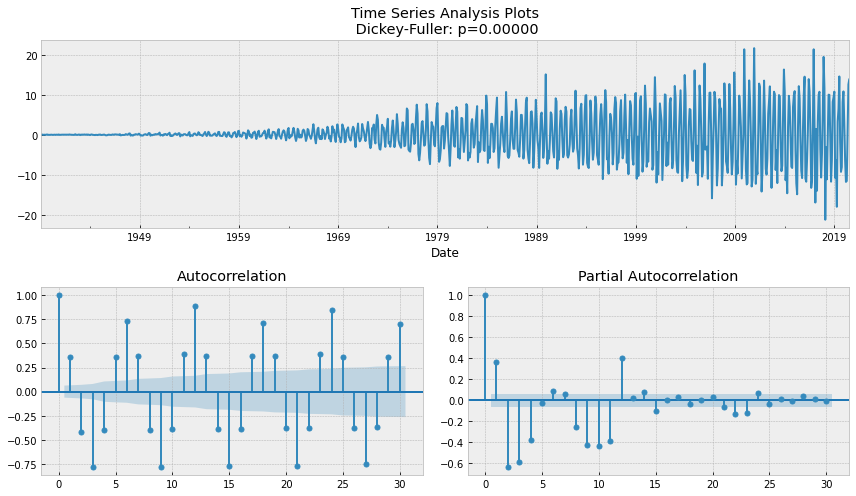

In [259]:
tsplot(df_diff1[1:])

Test statistic = -7.423
P-value = 0.000


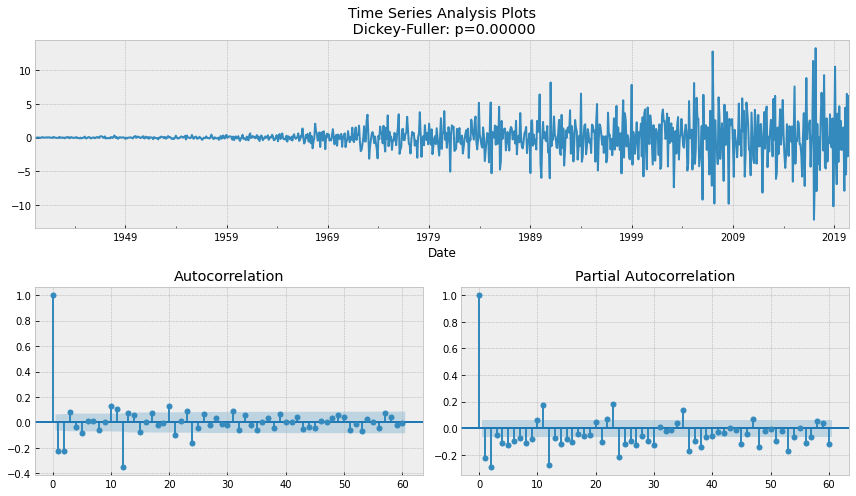

In [260]:
df_sdiff1 = df_diff1 - df_diff1.shift(12)
tsplot(df_sdiff1[12+1:],lags=60)

# Best model:  ARIMA(3,1,1)(2,0,2)[12] 
# Manual :    ARIMA(2,1,2)(2,1,1)[12] 

- $p$ is most probably 2 since it is the last significant lag on the PACF, after which, most others are not significant. 
- $d$ equals 1 because we had first differences
- $q$ should be somewhere around 2 as well as seen on the ACF
- $P$ might be 2, since 12-th and 24-th lags are somewhat significant on the PACF
- $D$ again equals 1 because we performed seasonal differentiation
- $Q$ is probably 1. The 12-th lag on ACF is significant while the 24-th is not.

Let's test various models and see which one is better.

In [261]:
ps = range(2, 4)
for i in ps:
    print(i)

2
3


In [262]:
# setting initial values and some bounds for them
ps = range(2, 4)
d=1 
qs = range(2, 4)
Ps = range(0, 3)
D=1 
Qs = range(0, 3)
s = 12 # season length is still 12

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [263]:
def optimizeSARIMA(series,parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        series - time-series data
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(series, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [264]:
%%time
result_table = optimizeSARIMA(df['Energy Production'],parameters_list, d, D, s)


Wall time: 5min 56s


In [265]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df['Energy Production'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                       Energy Production   No. Observations:                  979
Model:             SARIMAX(3, 1, 3)x(2, 1, [1, 2], 12)   Log Likelihood               -1906.347
Date:                                 Sun, 30 Aug 2020   AIC                           3834.695
Time:                                         17:43:01   BIC                           3888.300
Sample:                                     01-01-1939   HQIC                          3855.103
                                          - 07-01-2020                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1133      0.055     -2.046      0.041      -0.222      -0

In [266]:
# AUTO model:  ARIMA(3,1,1)(2,0,2)[12] 
# Initial :    ARIMA(2,1,2)(2,1,1)[12] 
# Final   :    ARIMA(3,1,3)(2,1,[1,2])[12]

# Lets inspect the residuals

Test statistic = -31.162
P-value = 0.000


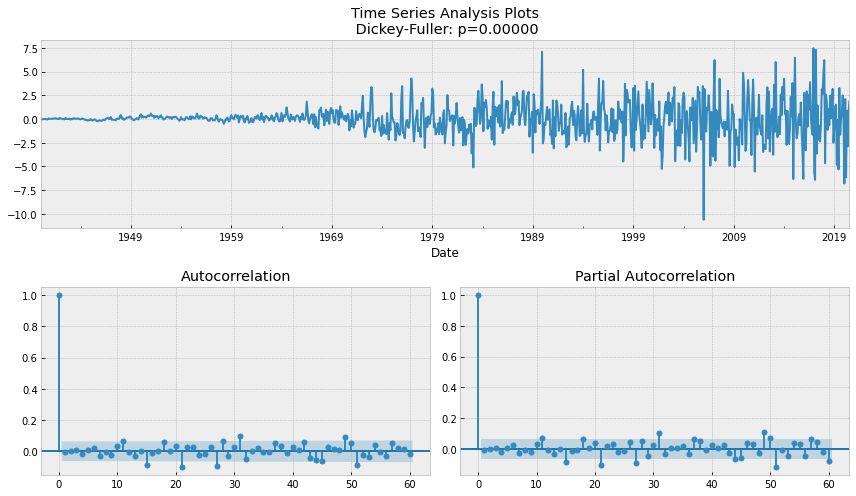

In [267]:
tsplot(best_model.resid[12+1:], lags=60)

It is clear that the residuals are stationary, and there are no apparent autocorrelations. Let's make predictions using our model.

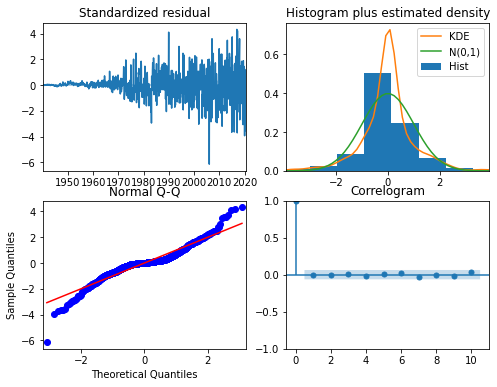

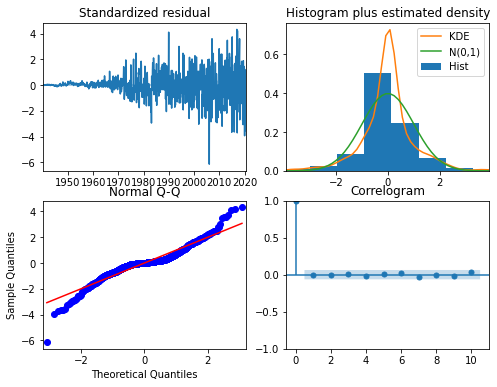

In [268]:
best_model.plot_diagnostics()

# Validating forecasts

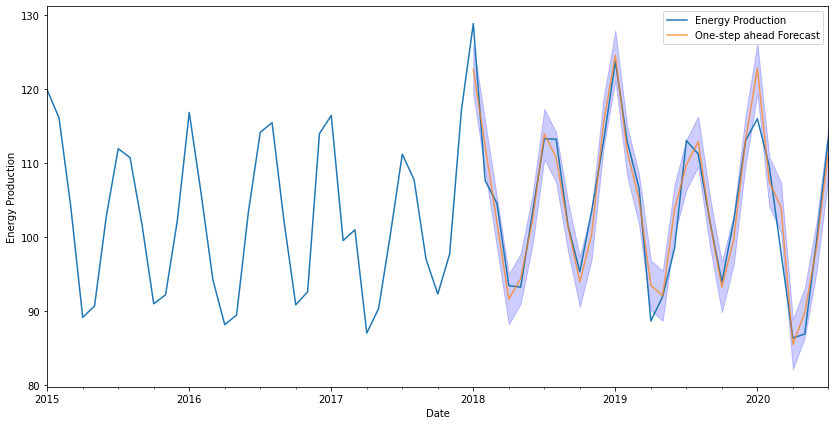

In [283]:
pred = best_model.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df.loc['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Energy Production')
plt.legend()
plt.show()

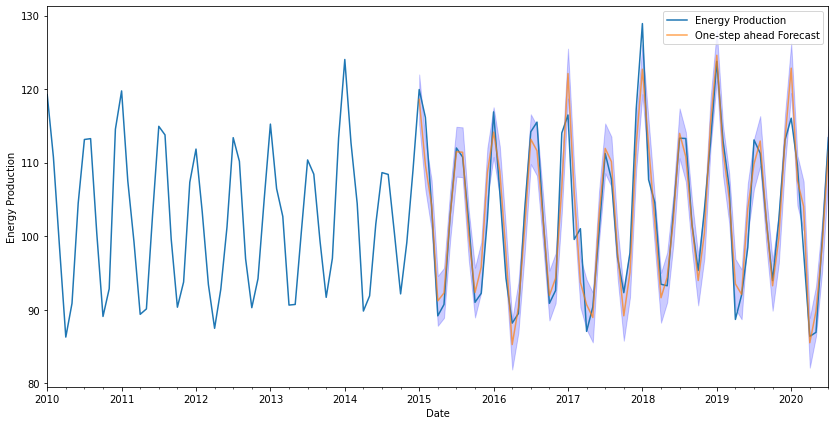

In [284]:
pred = best_model.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df.loc['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Energy Production')
plt.legend()
plt.show()

In [315]:
pred.predicted_mean

2015-01-01    118.591088
2015-02-01    109.669640
2015-03-01    104.228628
2015-04-01     91.187585
2015-05-01     92.263740
                 ...    
2020-03-01    104.040039
2020-04-01     85.490688
2020-05-01     89.782558
2020-06-01     98.706818
2020-07-01    111.546090
Freq: MS, Length: 67, dtype: float64

In [323]:
# y_truth = df.loc['2015':]
# y_truth- (pred.predicted_mean)

In [324]:
# y_forecasted = pred.predicted_mean
# y_truth = df.loc['2015-01-01':]
# mse = ((y_forecasted - y_truth) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Producing and visualizing forecasts

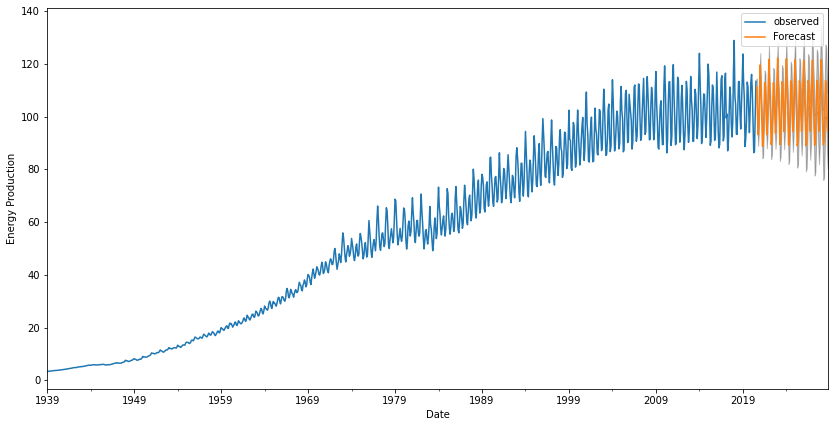

In [327]:
pred_uc = best_model.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = df['Energy Production'].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Energy Production')
plt.legend()
plt.show()

In [334]:
forecast1 = pd.DataFrame(pred_uc.predicted_mean, columns=['Prediction']).reset_index()
forecast1.columns = ['Date','Energy Production']
forecast1

,Date,Energy Production
0,2020-08-01,111.123668
1,2020-09-01,101.728293
2,2020-10-01,93.092472
3,2020-11-01,98.046044
4,2020-12-01,111.512112
...,...,...
95,2028-07-01,113.751048
96,2028-08-01,112.346960
97,2028-09-01,102.111676
98,2028-10-01,94.534093


In [335]:
import plotly.express as px
fig = px.line(forecast1, x = 'Date',y = 'Energy Production',title = 'Energy_Production')

fig.update_xaxes(
    rangeslider_visible= True,
    rangeselector=dict(
                        buttons = list([
                        dict(count = 1,label = '1m',step='month',stepmode = "backward"),
                        dict(count = 2,label = '6m',step='month',stepmode = "backward"),
                        dict(count = 3,label = '6mYTD',step='month',stepmode = "todate"),
                        dict(count = 4,label = '5y',step='year',stepmode = "backward"),
                        dict(count = 5,label = '10y',step='year',stepmode = "backward"),
                        dict(step= 'all')
                            ])        
                        )
                   )
fig.show()

In [280]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps, return_conf_int=True)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)
    plt.show();

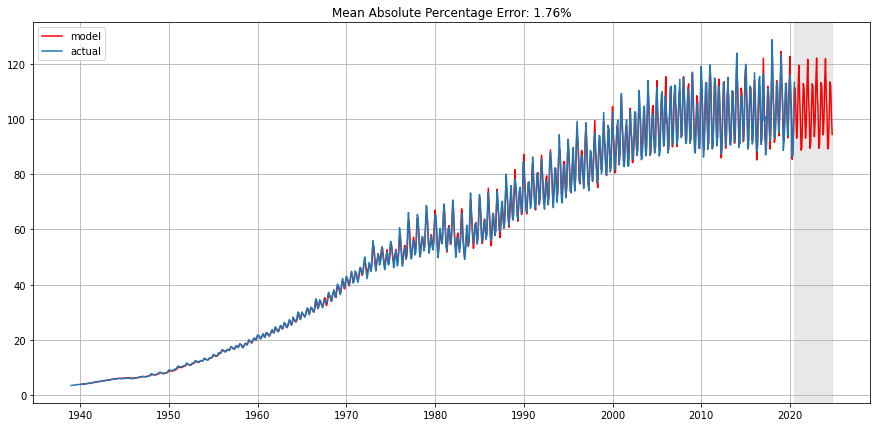

In [281]:
plotSARIMA(df, best_model, 50)

In the end, we got very adequate predictions. Our model was wrong by 1.76% on average, which is very, very good.
However, the overall costs of preparing data, making the series stationary, and selecting parameters might not be
worth this accuracy.

# Auto ARIMA

In [387]:
import pmdarima as pm
import time
#by default auto arima uses AIC,the lower aic the model is good
%time
model = pm.auto_arima(df['Energy Production'],
                      m = 12, seasonal = True,
                      start_p = 0,start_q=0,max_p=3, max_q=3,max_order=4,test='adf',error_action = 'ignore',
                      suppress_warnings =True,
                      stepwise =True,trace = True)

Wall time: 0 ns
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=4168.501, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6129.227, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5283.133, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6127.630, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=5387.444, Time=0.29 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=4165.433, Time=3.27 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=4157.723, Time=7.09 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=4208.789, Time=6.26 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=4126.450, Time=8.30 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4134.321, Time=3.87 sec
 ARIMA(1,1,0)(1,0,1)[12]

 ARIMA(3,1,1)(2,0,2)[12]             : AIC=3957.019, Time=6.83 sec

In [388]:
model.aic()

3957.019210187945

In [389]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  979
Model:             SARIMAX(3, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood               -1969.510
Date:                                 Fri, 28 Aug 2020   AIC                           3957.019
Time:                                         10:49:51   BIC                           4000.989
Sample:                                              0   HQIC                          3973.749
                                                 - 979                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5770      0.023     25.168      0.000       0.532       0.622
ar.L2         -0.0874      0.023     -3.823      0.000      -0.132      -0.043
ar.L3          0.0564      0.026      2.154      0.031       0.005       0.108
ma.L1         -0.9450      0.012    -75.955      0.000      -0.969      -0.921
ar.S.L12       0.6141      0.148      4.158      0.000       0.325       0.904
ar.S.L24       0.3795      0.146      2.596      0.009       0.093       0.666
ma.S.L12      -0.2152      0.148     -1.454      0.146      -0.505       0.075
ma.S.L24      -0.3737      0.091     -4.127      0.000      -0.551      -0.196
sigma2         3.1687      0.091     34.772      0.000       2.990       3.347
===================================================================================
Ljung-Box (Q):                      110.12   Jarque-Bera (JB):               626.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             123.01   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [390]:
model.arparams()

array([ 0.57701871, -0.08744504,  0.05641798])

In [391]:
print ("Sum of AR coefficients:", (0.57701871 -0.08744504 +  0.05641798))

Sum of AR coefficients: 0.54599165


## Train Test Split

In [392]:
train = df.loc['2000':'2018']
test  = df.loc['2019':]
print(train.shape)
print(test.shape)

(228, 1)
(19, 1)


## Train the model

In [393]:
model.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

## Evaluate the model

In [394]:
forecast = model.predict(n_periods=19,return_conf_int=True)

In [395]:
type(forecast)

tuple

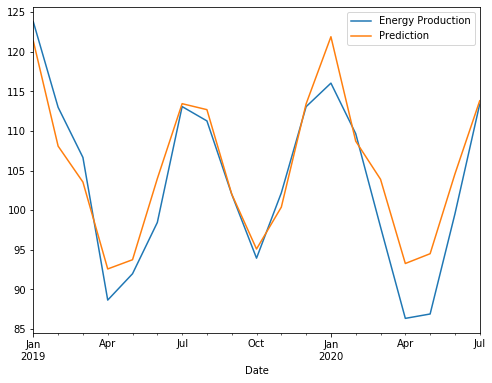

In [396]:
df_forecast = pd.DataFrame(forecast[0],index = test.index,columns=['Prediction'])
pd.concat([test,df_forecast],axis=1).plot()

In [397]:
df_final =  pd.merge(test, df_forecast, on='Date')

In [398]:
df_final

,Energy Production,Prediction
Date,,
2019-01-01,123.7687,121.345284
2019-02-01,112.9837,108.087179
2019-03-01,106.6593,103.553683
2019-04-01,88.6631,92.590902
2019-05-01,91.9852,93.753859
2019-06-01,98.4548,103.985474
2019-07-01,113.0791,113.445775
2019-08-01,111.2697,112.690594
2019-09-01,102.0185,102.031142


In [399]:
pd.concat([test,df_forecast],axis=1)

,Energy Production,Prediction
Date,,
2019-01-01,123.7687,121.345284
2019-02-01,112.9837,108.087179
2019-03-01,106.6593,103.553683
2019-04-01,88.6631,92.590902
2019-05-01,91.9852,93.753859
2019-06-01,98.4548,103.985474
2019-07-01,113.0791,113.445775
2019-08-01,111.2697,112.690594
2019-09-01,102.0185,102.031142


In [400]:
print("RMSE :%.3f" % np.sqrt(mse(df_final['Energy Production'], df_final['Prediction'])))
print("MAPE  :%.3f" % mean_absolute_percentage_error(df_final['Energy Production'], df_final['Prediction']))

RMSE :3.962
MAPE  :3.176


## Lets predict in future from 2020-08-01 to 2020-12-01.

In [401]:
forecast_range = pd.date_range(start='2019-01-01',periods=24,freq='MS')
forecast_range

DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [402]:
new_forecast = model.predict(n_periods=24,return_conf_int=True)

In [403]:
#Confidene interval
lower = pd.Series(new_forecast[1][:,0],index=forecast_range)
upper = pd.Series(new_forecast[1][:,1],index=forecast_range)

In [404]:
forcast_df = pd.DataFrame(new_forecast[0], index=forecast_range, columns=['Prediction'])

In [405]:
forcast_df = pd.concat([forcast_df, lower, upper], axis=1)
forcast_df.columns = ['Prediction','lower','upper']
forcast_df

,Prediction,lower,upper
2019-01-01,121.345284,115.699727,126.990840
2019-02-01,108.087179,101.457335,114.717024
2019-03-01,103.553683,96.801042,110.306324
2019-04-01,92.590902,85.775839,99.405965
2019-05-01,93.753859,86.882965,100.624753
2019-06-01,103.985474,97.079031,110.891916
2019-07-01,113.445775,106.515604,120.375945
2019-08-01,112.690594,105.740574,119.640615
2019-09-01,102.031142,95.063018,108.999265
2019-10-01,95.107493,88.122527,102.092460


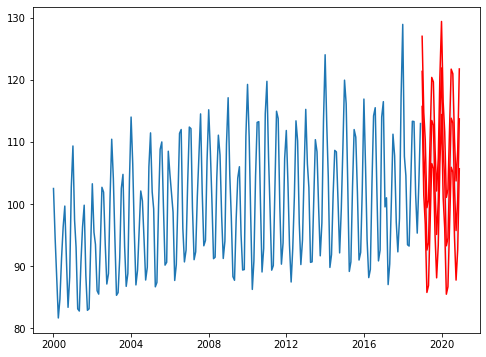

In [406]:
plt.plot(df.loc['2000':'2018'])
plt.plot(forcast_df,color='red')
plt.fill_between(forecast_range,lower,upper,alpha = 0.1)
plt.show()

## Now that we’ve evaluated our data on the test set and our satisfied with the performance, the next step would be to refit our model to our entire data set and then forecast into the real future.

In [407]:
model.fit(df)

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [408]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 979 entries, 1939-01-01 to 2020-07-01
Data columns (total 1 columns):
Energy Production    979 non-null float64
dtypes: float64(1)
memory usage: 55.3 KB


In [409]:
forecast_range = pd.date_range(start='2020-08-01',periods=24,freq='MS' )
forecast_range

DatetimeIndex(['2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', freq='MS')

In [410]:
forecast_ahead = model.predict(n_periods=24,return_conf_int=True)

In [411]:
#Confidene interval
lower = pd.Series(forecast_ahead[1][:,0],index=forecast_range)
upper = pd.Series(forecast_ahead[1][:,1],index=forecast_range)

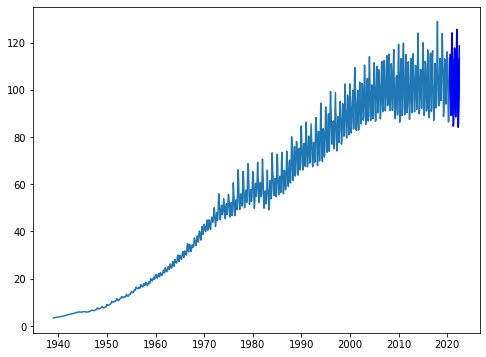

In [412]:
forcast_df = pd.DataFrame(forecast_ahead[0], index=forecast_range, columns=['Prediction'])
forcast_df = pd.concat([forcast_df, lower, upper], axis=1)
forcast_df.columns = ['Prediction','lower','upper']
plt.plot(df['Energy Production'])
plt.plot(forcast_df,color='blue')
plt.fill_between(forecast_range,lower,upper,alpha = 0.5)
plt.show()

In [413]:
forcast_df

,Prediction,lower,upper
2020-08-01,111.419584,107.930660,114.908508
2020-09-01,101.059731,96.932378,105.187084
2020-10-01,93.423428,89.136376,97.710481
2020-11-01,99.370946,94.997533,103.744359
2020-12-01,112.621638,108.190328,117.052948
2021-01-01,119.629216,115.158314,124.100117
2021-02-01,109.027291,104.526154,113.528429
2021-03-01,100.859207,96.332461,105.385953
2021-04-01,89.138287,84.588499,93.688075
2021-05-01,90.287134,85.715817,94.858451


# Using FB Prophet model

In [346]:
from fbprophet import Prophet

In [347]:
data = pd.read_csv('Electric_Production.csv')
df = data.copy()
df.columns = ['Date','EnergyProduction']
df.head()

,Date,EnergyProduction
0,1939-01-01,3.3842
1,1939-02-01,3.4100
2,1939-03-01,3.4875
3,1939-04-01,3.5133
4,1939-05-01,3.5133


In [348]:
df = df[df['Date']> '1999-12-01']
df

,Date,EnergyProduction
732,2000-01-01,102.4971
733,2000-02-01,94.5218
734,2000-03-01,88.3463
735,2000-04-01,81.6662
736,2000-05-01,84.7235
...,...,...
974,2020-03-01,97.8951
975,2020-04-01,86.3541
976,2020-05-01,86.9068
977,2020-06-01,99.5332


In [349]:
import plotly.express as px
fig = px.line(df, x = 'Date',y = 'EnergyProduction',title = 'Energy_Production')

fig.update_xaxes(
    rangeslider_visible= True,
    rangeselector=dict(
                        buttons = list([
                        dict(count = 1,label = '1m',step='month',stepmode = "backward"),
                        dict(count = 2,label = '6m',step='month',stepmode = "backward"),
                        dict(count = 3,label = '6mYTD',step='month',stepmode = "todate"),
                        dict(count = 4,label = '2y',step='year',stepmode = "backward"),
                        dict(count = 5,label = '3y',step='year',stepmode = "backward"),
                        dict(step= 'all')
                            ])        
                        )
                   )
fig.show()

In [350]:
# Adfuller test

   # Ho: Series possess a unit root and hence is not stationary
   # H1: Series is stationary

from statsmodels.tsa.stattools import adfuller
result = adfuller(df['EnergyProduction'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical values: {result[4]}')

if result[1] < 0.05:
    print('\nWe reject the null hypothesis i.e. Series is stationary')
else:
    print('\nWe fail to reject the null hypothesis i.e. Series is NOT stationary')

Test Statistics: -1.9755412249224928
p-value: 0.29739930099226997
Critical values: {'1%': -3.4589796764641, '5%': -2.8741347158661448, '10%': -2.573482381701992}

We fail to reject the null hypothesis i.e. Series is NOT stationary


In [352]:
df['Date'] = df['Date'].astype('datetime64[ns]')
df.set_index('Date', inplace=True)

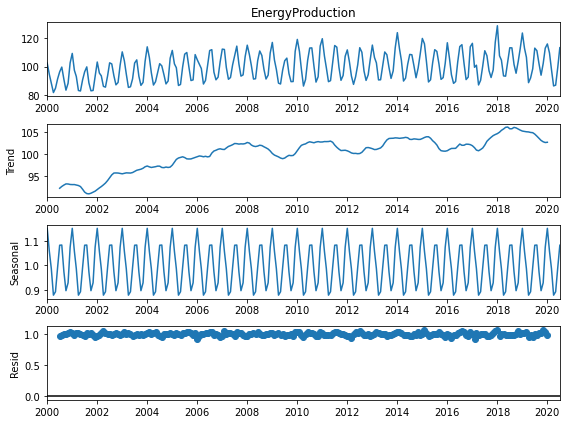

In [353]:
import statsmodels.api as sm
# deal with missing values.
df['EnergyProduction'].interpolate(inplace=True)
res = sm.tsa.seasonal_decompose(df['EnergyProduction'],model='multiplicative')
resplot = res.plot()

In [343]:
df.head()

,EnergyProduction
Date,
2000-01-01,102.4971
2000-02-01,94.5218
2000-03-01,88.3463
2000-04-01,81.6662
2000-05-01,84.7235


In [344]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2000-01-01 to 2020-07-01
Data columns (total 1 columns):
EnergyProduction    247 non-null float64
dtypes: float64(1)
memory usage: 3.9 KB


In [354]:
df_final = df.reset_index()[['Date','EnergyProduction']].rename({'Date':'ds','EnergyProduction':'y'}, axis='columns')

In [355]:
train = df_final[(df_final['ds']>='2000-01-01') & (df_final['ds']<='2020-01-01')]
test =  df_final[(df_final['ds']>'2020-01-01')]

In [356]:
train

,ds,y
0,2000-01-01,102.4971
1,2000-02-01,94.5218
2,2000-03-01,88.3463
3,2000-04-01,81.6662
4,2000-05-01,84.7235
...,...,...
236,2019-09-01,102.0185
237,2019-10-01,93.9518
238,2019-11-01,102.1902
239,2019-12-01,113.0698


In [357]:
test          

,ds,y
241,2020-02-01,109.6578
242,2020-03-01,97.8951
243,2020-04-01,86.3541
244,2020-05-01,86.9068
245,2020-06-01,99.5332
246,2020-07-01,113.3927


In [358]:
print(train.shape)
print(test.shape)

(241, 2)
(6, 2)


In [359]:
m = Prophet(interval_width=0.95, seasonality_mode='multiplicative')

In [360]:
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [361]:
m.params

OrderedDict([('k', array([[0.22175368]])),
             ('m', array([[0.7056394]])),
             ('delta',
              array([[-9.45749719e-09,  1.38807759e-08, -7.62602590e-09,
                      -2.94522348e-08, -8.37862881e-10, -5.68311755e-07,
                      -4.12088150e-07, -1.67133375e-06, -1.28115462e-02,
                      -3.83820519e-02, -6.20316257e-02, -6.56519071e-02,
                      -1.31154518e-02, -9.25731177e-10, -2.32883368e-09,
                       1.19446016e-08,  4.40553386e-09,  2.08389647e-08,
                       5.06204918e-08,  3.94663154e-03, -3.05815568e-09,
                      -3.15513046e-09,  1.61121254e-08,  7.24838636e-09,
                       4.97939246e-02]])),
             ('sigma_obs', array([[0.02148658]])),
             ('beta',
              array([[-0.01447606,  0.02101659,  0.04999381,  0.22640584,  0.06116751,
                       0.04633463,  0.03770431,  0.05170328, -0.00497924,  0.00254843,
                  

In [362]:
future = m.make_future_dataframe(periods=6,freq='MS')
future

,ds
0,2000-01-01
1,2000-02-01
2,2000-03-01
3,2000-04-01
4,2000-05-01
...,...
242,2020-03-01
243,2020-04-01
244,2020-05-01
245,2020-06-01


In [363]:
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2000-01-01,90.961929,98.194686,108.893554,90.961929,90.961929,0.138014,0.138014,0.138014,0.138014,0.138014,0.138014,0.0,0.0,0.0,103.515947
1,2000-02-01,91.083237,91.973494,102.743458,91.083237,91.083237,0.067615,0.067615,0.067615,0.067615,0.067615,0.067615,0.0,0.0,0.0,97.241862
2,2000-03-01,91.196718,83.465081,93.860694,91.196718,91.196718,-0.029291,-0.029291,-0.029291,-0.029291,-0.029291,-0.029291,0.0,0.0,0.0,88.525489
3,2000-04-01,91.318026,75.211497,86.169885,91.318026,91.318026,-0.117644,-0.117644,-0.117644,-0.117644,-0.117644,-0.117644,0.0,0.0,0.0,80.575004
4,2000-05-01,91.435421,77.088097,87.772585,91.435421,91.435421,-0.099481,-0.099481,-0.099481,-0.099481,-0.099481,-0.099481,0.0,0.0,0.0,82.339335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2020-03-01,105.162776,96.861881,107.094175,105.154500,105.168408,-0.029291,-0.029291,-0.029291,-0.029291,-0.029291,-0.029291,0.0,0.0,0.0,102.082470
243,2020-04-01,105.208454,87.815773,98.677181,105.192404,105.222681,-0.117644,-0.117644,-0.117644,-0.117644,-0.117644,-0.117644,0.0,0.0,0.0,92.831306
244,2020-05-01,105.252657,89.230138,100.639919,105.226953,105.274277,-0.099481,-0.099481,-0.099481,-0.099481,-0.099481,-0.099481,0.0,0.0,0.0,94.782019
245,2020-06-01,105.298335,100.439518,110.433656,105.264692,105.329783,0.000874,0.000874,0.000874,0.000874,0.000874,0.000874,0.0,0.0,0.0,105.390406


In [364]:
forecast[['ds','yhat','yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2000-01-01,103.515947,98.194686,108.893554
1,2000-02-01,97.241862,91.973494,102.743458
2,2000-03-01,88.525489,83.465081,93.860694
3,2000-04-01,80.575004,75.211497,86.169885
4,2000-05-01,82.339335,77.088097,87.772585


In [365]:
forecast[['ds','yhat','yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
242,2020-03-01,102.082470,96.861881,107.094175
243,2020-04-01,92.831306,87.815773,98.677181
244,2020-05-01,94.782019,89.230138,100.639919
245,2020-06-01,105.390406,100.439518,110.433656
246,2020-07-01,113.777897,108.405780,118.661145


In [366]:
df_final

,ds,y
0,2000-01-01,102.4971
1,2000-02-01,94.5218
2,2000-03-01,88.3463
3,2000-04-01,81.6662
4,2000-05-01,84.7235
...,...,...
242,2020-03-01,97.8951
243,2020-04-01,86.3541
244,2020-05-01,86.9068
245,2020-06-01,99.5332


In [367]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 16 columns):
ds                            247 non-null datetime64[ns]
trend                         247 non-null float64
yhat_lower                    247 non-null float64
yhat_upper                    247 non-null float64
trend_lower                   247 non-null float64
trend_upper                   247 non-null float64
multiplicative_terms          247 non-null float64
multiplicative_terms_lower    247 non-null float64
multiplicative_terms_upper    247 non-null float64
yearly                        247 non-null float64
yearly_lower                  247 non-null float64
yearly_upper                  247 non-null float64
additive_terms                247 non-null float64
additive_terms_lower          247 non-null float64
additive_terms_upper          247 non-null float64
yhat                          247 non-null float64
dtypes: datetime64[ns](1), float64(15)
memory usage: 31.0 KB


In [368]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 2 columns):
ds    247 non-null datetime64[ns]
y     247 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


In [369]:
forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]

,yhat,yhat_lower,yhat_upper
ds,,,
2000-01-01,103.515947,98.194686,108.893554
2000-02-01,97.241862,91.973494,102.743458
2000-03-01,88.525489,83.465081,93.860694
2000-04-01,80.575004,75.211497,86.169885
2000-05-01,82.339335,77.088097,87.772585
...,...,...,...
2020-03-01,102.082470,96.861881,107.094175
2020-04-01,92.831306,87.815773,98.677181
2020-05-01,94.782019,89.230138,100.639919


In [370]:
#df_predict = pd.concat([df_final.set_index('ds')[['y']], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]],axis=1)
df_predict = pd.concat([df_final.set_index('ds')[['y']], forecast.set_index('ds')[['yhat']]],axis=1)
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2000-01-01 to 2020-07-01
Data columns (total 2 columns):
y       247 non-null float64
yhat    247 non-null float64
dtypes: float64(2)
memory usage: 5.8 KB


In [371]:
df_predict.tail()

,y,yhat
ds,,
2020-03-01,97.8951,102.082470
2020-04-01,86.3541,92.831306
2020-05-01,86.9068,94.782019
2020-06-01,99.5332,105.390406
2020-07-01,113.3927,113.777897


<AxesSubplot:xlabel='ds'>

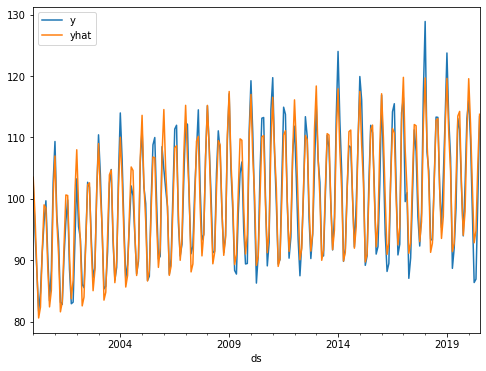

In [372]:
pd.plotting.register_matplotlib_converters()
df_predict.plot()

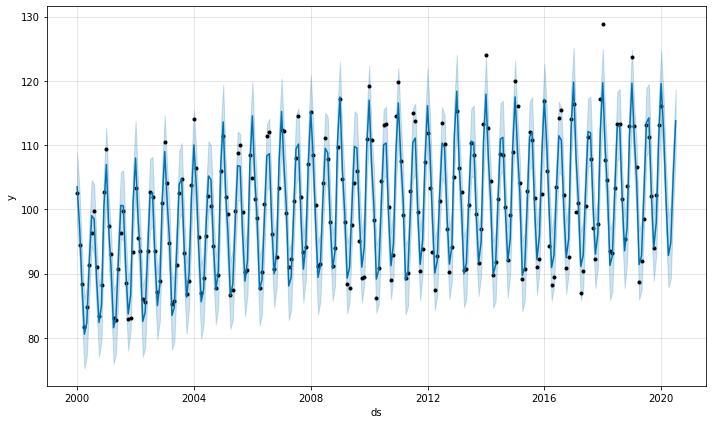

In [373]:
fig1 = m.plot(forecast)
#95% Confidence interval is the light blue color
#the black dots are actual values 
#the dark blue is the y_hat or forecasted value

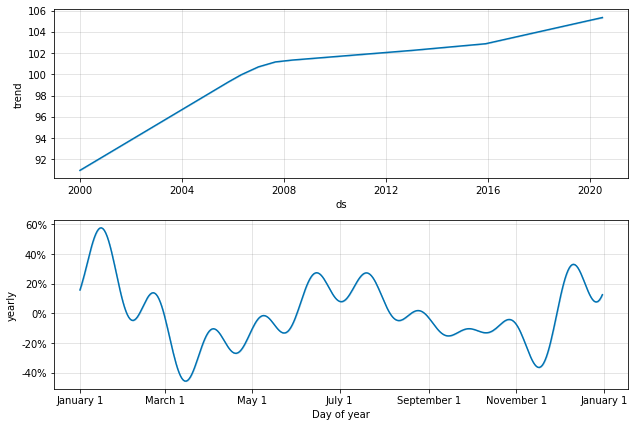

In [374]:
fig2 = m.plot_components(forecast)

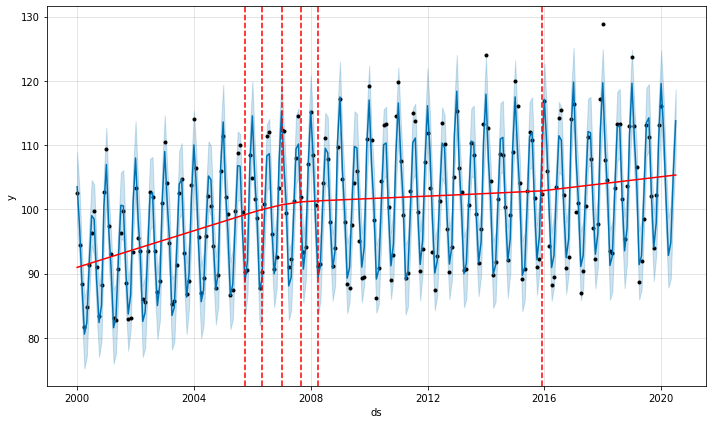

In [378]:
#Get layers to overlay significant changepoints on prophet forecast plot.
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),m,forecast,cp_color = "red",)

In [379]:
deltas = m.params['delta'].mean(0)
deltas

array([-9.45749719e-09,  1.38807759e-08, -7.62602590e-09, -2.94522348e-08,
       -8.37862881e-10, -5.68311755e-07, -4.12088150e-07, -1.67133375e-06,
       -1.28115462e-02, -3.83820519e-02, -6.20316257e-02, -6.56519071e-02,
       -1.31154518e-02, -9.25731177e-10, -2.32883368e-09,  1.19446016e-08,
        4.40553386e-09,  2.08389647e-08,  5.06204918e-08,  3.94663154e-03,
       -3.05815568e-09, -3.15513046e-09,  1.61121254e-08,  7.24838636e-09,
        4.97939246e-02])

In [380]:
range(len(deltas))

range(0, 25)

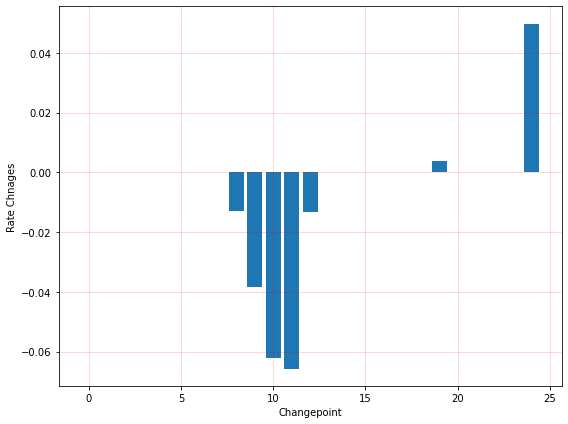

In [381]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)),deltas)
ax.grid(True,which='major',c='red',ls='-',alpha=0.2)
ax.set_ylabel('Rate Chnages')
ax.set_xlabel('Changepoint')
fig.tight_layout()
#Prophet plots around 25 chnage points

In [382]:
m.changepoints

8     2000-09-01
15    2001-04-01
23    2001-12-01
31    2002-08-01
38    2003-03-01
46    2003-11-01
53    2004-06-01
61    2005-02-01
69    2005-10-01
76    2006-05-01
84    2007-01-01
92    2007-09-01
99    2008-04-01
107   2008-12-01
115   2009-08-01
122   2010-03-01
130   2010-11-01
138   2011-07-01
145   2012-02-01
153   2012-10-01
160   2013-05-01
168   2014-01-01
176   2014-09-01
183   2015-04-01
191   2015-12-01
Name: ds, dtype: datetime64[ns]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


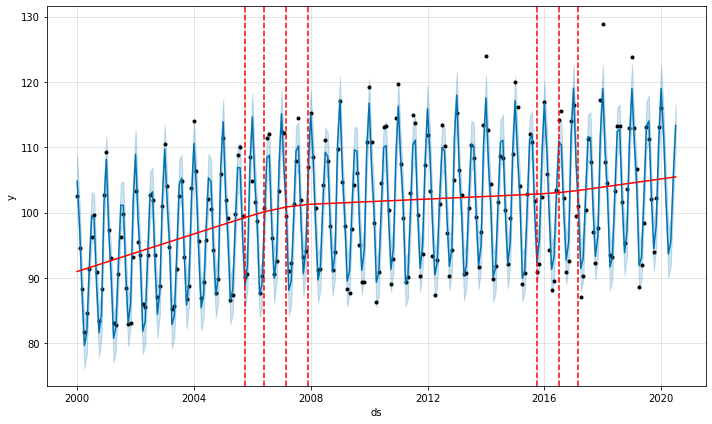

In [383]:
pro_change = Prophet(changepoint_range=0.9,yearly_seasonality=True)
forecast = pro_change.fit(train).predict(future)
fig = pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),pro_change,forecast)

In [384]:
from fbprophet.plot import plot_plotly
import plotly.offline as py

fig = plot_plotly(m,forecast) #this returns the plotly figure
py.iplot(fig)

### Prophet cross_validation
     cross_validation(model, horizon, period=None, initial=None)
     Computes forecasts from historical cutoff points. Beginning from (end - horizon), works backwards making cutoffs with      a spacing of period until initial is reached.
    Arguments
        ----------
        model: Prophet class object. Fitted Prophet model
        horizon: string with pd.Timedelta compatible style, e.g., '5 days',
            '3 hours', '10 seconds'.
        period: string with pd.Timedelta compatible style. Simulated forecast will
            be done at every this period. If not provided, 0.5 * horizon is used.
        initial: string with pd.Timedelta compatible style. The first training
            period will begin here. If not provided, 3 * horizon is used.

In [397]:
from fbprophet.diagnostics import cross_validation
#cv_results = cross_validation(model = m,initial = '731 days',horizon='365 days')
cv_results = cross_validation(model = m, horizon='2y')

INFO:fbprophet:Making 13 forecasts with cutoffs between 2005-12-31 14:31:12 and 2017-12-31 12:21:36


    period: If not provided, 0.5 * horizon is used.  i.e.    1 year
    initial: If not provided, 3 * horizon is used.   i.e.   6yrs 

In [399]:
np.unique(cv_results.cutoff, return_counts=True)

(array(['2005-12-31T14:31:12.000000000', '2006-12-31T20:20:24.000000000',
        '2008-01-01T02:09:36.000000000', '2008-12-31T07:58:48.000000000',
        '2009-12-31T13:48:00.000000000', '2010-12-31T19:37:12.000000000',
        '2012-01-01T01:26:24.000000000', '2012-12-31T07:15:36.000000000',
        '2013-12-31T13:04:48.000000000', '2014-12-31T18:54:00.000000000',
        '2016-01-01T00:43:12.000000000', '2016-12-31T06:32:24.000000000',
        '2017-12-31T12:21:36.000000000'], dtype='datetime64[ns]'),
 array([25, 24, 23, 24, 25, 24, 23, 24, 25, 24, 23, 24, 25], dtype=int64))

In [402]:
13 * 12 * 2

312

In [403]:
cv_results[cv_results.cutoff=="2005-12-31 14:31:12"]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2006-01-01,115.450532,111.671543,119.341384,104.8128,2005-12-31 14:31:12
1,2006-02-01,105.943836,102.353839,109.616754,101.6310,2005-12-31 14:31:12
2,2006-03-01,100.427149,96.410818,104.265575,98.6932,2005-12-31 14:31:12
3,2006-04-01,90.503276,86.934769,94.018286,87.7034,2005-12-31 14:31:12
4,2006-05-01,90.786625,86.898951,94.495282,90.2388,2005-12-31 14:31:12
5,2006-06-01,98.944333,95.224409,102.866313,100.7836,2005-12-31 14:31:12
6,2006-07-01,108.822272,105.182063,112.623560,111.3696,2005-12-31 14:31:12
7,2006-08-01,110.329001,106.707172,113.778283,111.9898,2005-12-31 14:31:12
8,2006-09-01,99.361249,95.659063,103.207362,96.1212,2005-12-31 14:31:12
9,2006-10-01,92.110268,88.222558,96.129589,90.6869,2005-12-31 14:31:12


In [404]:
cv_results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2006-01-01,115.450532,111.671543,119.341384,104.8128,2005-12-31 14:31:12
1,2006-02-01,105.943836,102.353839,109.616754,101.6310,2005-12-31 14:31:12
2,2006-03-01,100.427149,96.410818,104.265575,98.6932,2005-12-31 14:31:12
3,2006-04-01,90.503276,86.934769,94.018286,87.7034,2005-12-31 14:31:12
4,2006-05-01,90.786625,86.898951,94.495282,90.2388,2005-12-31 14:31:12
...,...,...,...,...,...,...
308,2019-09-01,100.466497,95.318301,105.185693,102.0185,2017-12-31 12:21:36
309,2019-10-01,92.066190,86.802233,97.192926,93.9518,2017-12-31 12:21:36
310,2019-11-01,94.666004,89.681207,99.877911,102.1902,2017-12-31 12:21:36
311,2019-12-01,108.142806,102.794672,113.774401,113.0698,2017-12-31 12:21:36


In [405]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,59 days 16:01:12,25.581103,5.057777,4.035123,0.036627,0.029864,0.612903
1,59 days 16:44:24,25.779172,5.077319,4.068100,0.037016,0.032499,0.612903
2,59 days 17:27:36,25.368149,5.036680,3.959723,0.036122,0.032499,0.612903
3,59 days 21:50:24,25.244960,5.024436,3.931083,0.035971,0.032499,0.612903
4,59 days 22:33:36,23.450748,4.842597,3.832626,0.035316,0.032499,0.612903
...,...,...,...,...,...,...,...
278,700 days 05:06:00,17.934138,4.234872,3.559393,0.034977,0.025624,0.709677
279,730 days 09:28:48,18.628655,4.316093,3.685819,0.036019,0.026370,0.677419
280,730 days 10:12:00,18.778355,4.333400,3.743838,0.036514,0.026370,0.677419
281,730 days 10:55:12,18.649379,4.318493,3.705963,0.036012,0.026370,0.677419


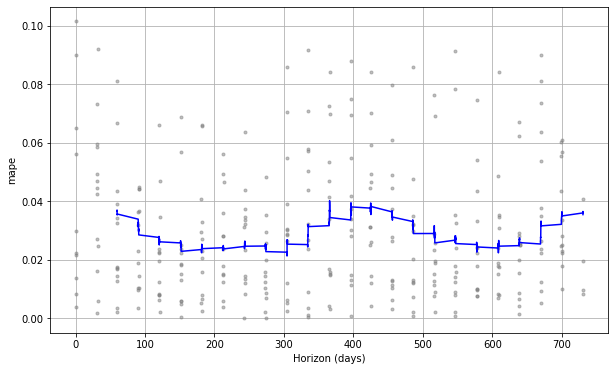

In [406]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_results, metric='mape')

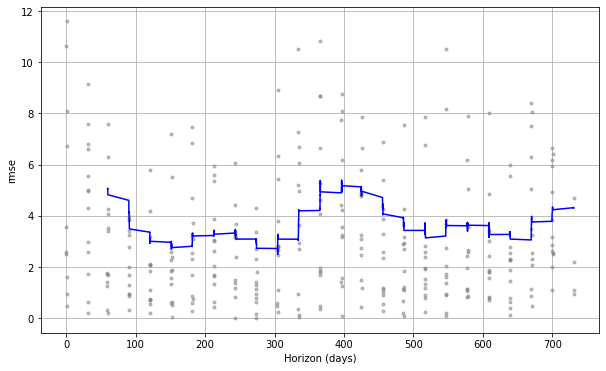

In [407]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_results, metric='rmse')